In [1]:
from mindspore import nn, ops, Tensor, jit_class, set_context, set_seed
import mindspore as ms
import numpy as np

set_seed(123456)

In [2]:
set_context(mode=ms.PYNATIVE_MODE, device_target="GPU")

In [3]:
from mindspore.common.initializer import Normal

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Dense(1, 32, Normal())
        self.fc2 = nn.Dense(32, 32, Normal())
        self.fc3 = nn.Dense(32, 32, Normal())
        self.fc4 = nn.Dense(32, 32, Normal())
        self.fc5 = nn.Dense(32, 32, Normal())
        self.fcout = nn.Dense(32, 1, Normal())
        self.act = ops.Tanh()

    def construct(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        x = self.fcout(x)

        return x

model = Network()
model

Network<
  (fc1): Dense<input_channels=1, output_channels=32, has_bias=True>
  (fc2): Dense<input_channels=32, output_channels=32, has_bias=True>
  (fc3): Dense<input_channels=32, output_channels=32, has_bias=True>
  (fc4): Dense<input_channels=32, output_channels=32, has_bias=True>
  (fc5): Dense<input_channels=32, output_channels=32, has_bias=True>
  (fcout): Dense<input_channels=32, output_channels=1, has_bias=True>
  >

In [4]:
samples = 2**15

class MyIterable:
    def __init__(self):
        
        self._index = 0
        self._data = np.random.uniform(-np.pi, np.pi, size=(samples, 1)).astype(np.float32)
        self._ic = np.zeros((samples, 1)).astype(np.float32)

    def __next__(self):
        if self._index >= len(self._data):
            raise StopIteration
        else:
            item = (self._data[self._index], self._ic[self._index])
            self._index += 1
            return item
        
    def __iter__(self):
        self._index = 0
        return self
    
    def __len__(self):
        return len(self._data)
    
dataset = ms.dataset.GeneratorDataset(source=MyIterable(), column_names=["data", "label"])
print(dataset)

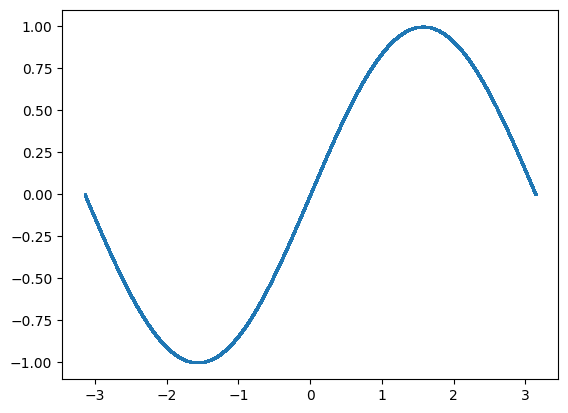

In [5]:
from matplotlib import pyplot as plt
test_data = np.random.uniform(-np.pi, np.pi, size=(2**17, 1)).astype(np.float32)
test_label = np.sin(test_data)
plt.scatter(test_data, test_label, s=1)
plt.show()

In [6]:
import sympy

@jit_class
class MyLossFun:
    def __init__(self, net):
        self.net = net
        self.reduce_mean = ops.ReduceMean()
        self.loss = nn.MSELoss()

    def compute_loss(self, pde_data, ic_data):
        # pde_loss = self.reduce_mean(self.pde(pde_data), Tensor(np.array([0.0]).astype(np.float32), ms.float32))
        # ic_loss = self.reduce_mean(self.ic(ic_data), Tensor(np.array([0.0]).astype(np.float32), ms.float32))

        pde_loss = self.reduce_mean(self.loss(self.net(pde_data), ops.sin(pde_data)))
        ic_loss = self.reduce_mean(self.loss(self.net(ic_data), Tensor(np.array([0.0]).astype(np.float32), ms.float32)))

        return pde_loss + ic_loss

    # def pde(self, data):
    #     x = sympy.Symbol("x")
    #     y = sympy.Function('y')(x)

    #     eq = y.diff(x) - ops.cos(x)

    # def ic(self, data):
    #     out = self.net(data)
    #     return out 


In [7]:
optimizer = nn.Adam(model.trainable_params(), learning_rate=5e-3)
loss_fn = MyLossFun(model)

In [8]:
batch_size=2**5
dataset = dataset.batch(batch_size=batch_size)

In [9]:
def train_loop(model, dataset, loss_fn, optimizer):
    def forwad_fn(pde_data, ic_data):
        # logits = model(pde_data)
        loss = loss_fn.compute_loss(pde_data, ic_data)
        return loss
    
    grad_fn = ops.value_and_grad(forwad_fn, None, optimizer.parameters, has_aux=False)
    
    def train_step(pde_data, ic_data):
        loss, grads = grad_fn(pde_data, ic_data)
        loss = ops.depend(loss, optimizer(grads))
        return loss
    
    size = dataset.get_dataset_size()
    print(size)
    model.set_train()
    for batch, (pde_data, ic_data) in enumerate(dataset.create_tuple_iterator()):
        # print(data.shape, "  ", label.shape)
        loss = train_step(pde_data, ic_data)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
        

In [10]:
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for pde_data, ic_data in dataset.create_tuple_iterator():
        total += 2*len(pde_data)
        pred_pde = model(pde_data)
        pred_ic = model(ic_data)
        test_loss += loss_fn.compute_loss(pde_data, ic_data).asnumpy()
        correct += (ops.isclose(pred_pde, ops.sin(pde_data), rtol=1e-2, atol=1e-8)).asnumpy().sum()
        correct += (ops.isclose(pred_ic, ops.sin(ic_data), rtol=1e-2, atol=1e-8)).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
import time
for epoch in range(10):
    print("epoch: ", epoch + 1)
    time_beg = time.time()
    train_loop(model, dataset, loss_fn, optimizer)
    time_cost = time.time()-time_beg
    mean_step_cost = time_cost * batch_size / samples * 1000 
    print(f"Train: \n time cost: {time_cost:>4f}s\nmean step time cost: {mean_step_cost:>5f}ms" )
    test_loop(model, dataset, loss_fn)
    print("="*100)

epoch:  1
1024
loss: 0.510456  [  0/1024]
loss: 0.063223  [100/1024]
loss: 0.068175  [200/1024]
loss: 0.043327  [300/1024]
loss: 0.026262  [400/1024]
loss: 0.009044  [500/1024]
loss: 0.006557  [600/1024]
loss: 0.007570  [700/1024]
loss: 0.003248  [800/1024]
loss: 0.004056  [900/1024]
loss: 0.004845  [1000/1024]
Train: 
 time cost: 40.926142s
mean step time cost: 39.966935ms
Test: 
 Accuracy: 2.2%, Avg loss: 0.005561 

epoch:  2
1024
loss: 0.007078  [  0/1024]
loss: 0.003362  [100/1024]
loss: 0.007288  [200/1024]
loss: 0.006159  [300/1024]
loss: 0.006741  [400/1024]
loss: 0.005309  [500/1024]
loss: 0.002355  [600/1024]
loss: 0.005567  [700/1024]
loss: 0.001903  [800/1024]
loss: 0.004990  [900/1024]
loss: 0.006085  [1000/1024]
Train: 
 time cost: 39.264211s
mean step time cost: 38.343956ms
Test: 
 Accuracy: 2.6%, Avg loss: 0.004481 

epoch:  3
1024
loss: 0.005706  [  0/1024]
loss: 0.002424  [100/1024]
loss: 0.003322  [200/1024]
loss: 0.001354  [300/1024]
loss: 0.002573  [400/1024]
loss: 

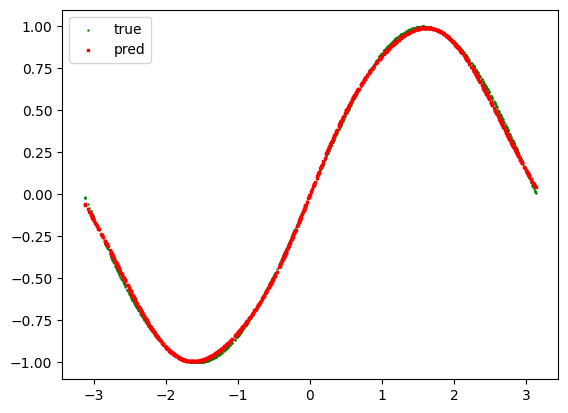

In [12]:
valid_data = np.random.uniform(-np.pi, np.pi, size=(1000, 1))
true_label = np.sin(valid_data)
pred_label = model(Tensor(valid_data, ms.float32))
plt.scatter(valid_data, true_label, color="green", s=2, marker=".")
plt.scatter(valid_data, pred_label, color="red", s=2, marker="s")
plt.legend(["true", "pred"])
plt.show()